In [51]:
#Homework 6
#Arthur Sant'Ana

In [52]:
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# my modules
from ReadFile import Read
# Step 1: modify CenterOfMass so that COM_P now takes a parameter specifying 
# by how much to decrease RMAX instead of a factor of 2
from CenterOfMass2 import CenterOfMass


# for bonus:
# scipy provides powerful functions for scientific computing
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [53]:
def OrbitCOM(galaxy, start, end, n):
    """function that loops over all the desired snapshots to compute the COM pos and vel as a function of time.
    inputs:
        galaxy: string
            Name of galaxy 
        start: int 
            Starting snapshot 
        end: int
            Snapshot to end at 
        n: int
            Time evolution increment in snapshots 
          
    outputs: 
        Saves array of the orbital parameters of the galaxy evolved over the snapshot range to a .txt file. 
        Has 7 columns of floats:
        t: Time in Gyr
        x: COM x position in kpc
        y: COM y position in kpc
        z: COM z position in kpc
        vx: x-component of COM velocity in km/s
        vy: y-component of COM velocity in km/s
        vz: z-component pf COM velocity in km/s
    """
    
    # compose the filename for output
    fileout = f"Orbit_{galaxy}.txt"
    
    #  set tolerance and VolDec for calculating COM_P in CenterOfMass
    # for M33 that is stripped more, use different values for VolDec
    delta = 0.1 # kpc
    if galaxy == 'M33':
        # M33 will be severely tidally stripped towards end of simulation 
        # Use 4 for tighter convergence of COM position 
        volDec = 4 
    else:
        volDec = 2

    
    # generate the snapshot id sequence 
    # it is always a good idea to also check if the input is eligible (not required)
    snap_ids = np.arange(start, end, n)
    
    # raise execption if snap_ids empty
    if not snap_ids.any():
        raise Exception("Invalid start and end values for given n.")
    
    # initialize the array for orbital info: t, x, y, z, vx, vy, vz of COM
    orbit = np.zeros([len(snap_ids), 7])
    
    # a for loop 
    for i, snap_id in enumerate(snap_ids): # loop over files
        # compose the data filename (be careful about the folder)
        ilbl = '000' + str(snap_id)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        
        # Due to the high number of simulation files, they will not be pushed to GitHub page
        # Instead are stored on my local device in directory above GitHub repo titled SimFiles
        filename= "%s/%s_"%(galaxy, galaxy) + ilbl + '.txt'
        
        # Initialize an instance of CenterOfMass class, using disk particles
        COM = CenterOfMass(filename, 2)

        # Store the COM pos and vel. Remember that now COM_P required VolDec
        COM_p = COM.COM_P(volDec, delta)
        COM_v = COM.COM_V(COM_p[0], COM_p[1], COM_p[2])
       
    
        # store the time, pos, vel in ith element of the orbit array,  without units (.value) 
        # note that you can store 
        # a[i] = var1, *tuple(array1)
        orbit[i] = COM.time.value/1000, *tuple(COM_p.value), *tuple(COM_v.value)
        
        # print snap_id to see the progress
        print(snap_id)
        
    # write the data to a file
    # we do this because we don't want to have to repeat this process 
    # this code should only have to be called once per galaxy.
    np.savetxt(fileout, orbit, fmt = "%11.3f"*7, comments='#',
               header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                      .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))

In [54]:
# Recover the orbits and generate the COM files for each galaxy
# read in 800 snapshots in intervals of n=5
# Note: This might take a little while - test your code with a smaller number of snapshots first! 

OrbitCOM("MW",0,800,5)
OrbitCOM("M31",0,800,5)
OrbitCOM("M33",0,800,5)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500


In [55]:
# Read in the data files for the orbits of each galaxy that you just created
# headers:  t, x, y, z, vx, vy, vz
# using np.genfromtxt

MW_Orbit = np.genfromtxt('Orbit_MW.txt') 
M31_Orbit = np.genfromtxt('Orbit_M31.txt') 
M33_Orbit = np.genfromtxt('Orbit_M33.txt') 


In [59]:
# function to compute the magnitude of the difference between two vectors 
# You can use this function to return both the relative position and relative velocity for two 
# galaxies over the entire orbit  
def RelativeMagnitude(a, b): 
    """
    Function to calculate an array of the relative magnitudes between a pair of 3D arrays.
    Example: center of mass position (x,y,z) of galaxy or velocity (vx, vy, vz)
    
    INPUTS:
        array1: 3D numpy array
        array2: 3D numpy array
        
    OUTPUTS:
        relmag: 1D numpy array
            Array of the relative vector magnitudes (array1 - array2)
    """
    A = a[:,0] - b[:,0] # compute relative "x" values
    B = a[:,1] - b[:,1] # compute relative "y" values
    C = a[:,2] - b[:,2] # compute relative "z" values
    
    relmag = np.sqrt(A**2 + B**2 + C**2) # compute magnitudes
    
    return relmag

In [61]:
# Determine the magnitude of the relative position and velocities 
#MW and M31
MW_M31_Sep = RelativeMagnitude(MW_Orbit[:, 1:4], M31_Orbit[:, 1:4]) 
MW_M31_RelVel = RelativeMagnitude(MW_Orbit[:, 4:7], M31_Orbit[:, 4:7]) 

# of M33 and M31
M31_M33_Sep = RelativeMagnitude(M33_Orbit[:, 1:4], M31_Orbit[:, 1:4])
M31_M33_RelVel = RelativeMagnitude(M33_Orbit[:, 4:7], M31_Orbit[:, 4:7])

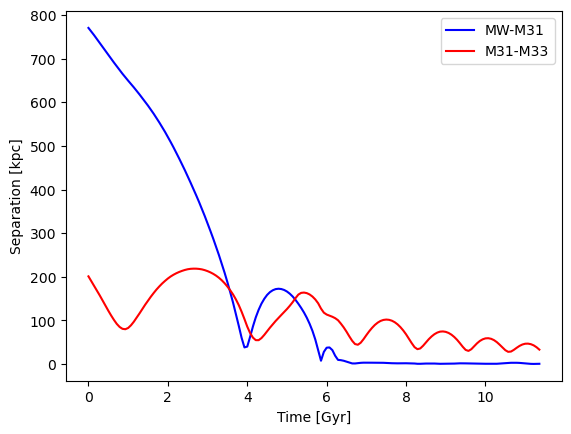

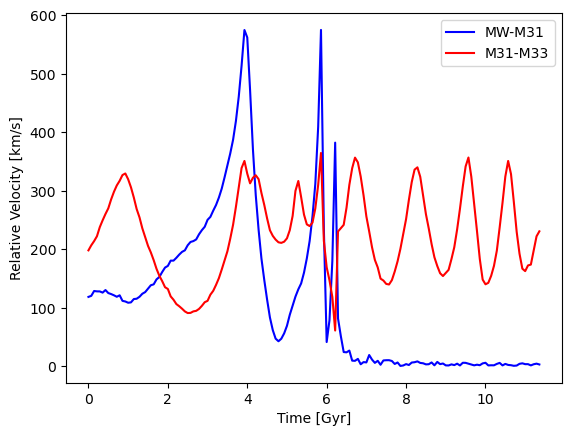

In [67]:

# Plot the Orbit of the galaxies 
#################################
times = MW_Orbit[:,0]


plt.plot(times, MW_M31_Sep, c='blue', label='MW-M31')
plt.plot(times, M31_M33_Sep, c='red', label='M31-M33')
plt.legend()
plt.xlabel('Time [Gyr]')
plt.ylabel('Separation [kpc]')
plt.savefig('MW_M31_M33_Sep.png')

plt.show()

# Plot the orbital velocities of the galaxies 
#################################
times = MW_Orbit[:,0]


plt.plot(times, MW_M31_RelVel, c='blue', label='MW-M31')
plt.plot(times, M31_M33_RelVel, c='red', label='M31-M33')
plt.legend()
plt.xlabel('Time [Gyr]')
plt.ylabel('Relative Velocity [km/s]')
plt.savefig('MW_M31_M33_RelVel.png')

plt.show()


# Answering Questions


Q2: the velocity curves appear to be the largest when the objects are closer together and their COMs are crossing each other, they are accelerating

Q3:
    a) The merger seems to happen in 6.5 Gyr, then the separation stabilizes
    b) M33's orbit seems to decay after the merger, making it come closer to the new merged galaxies 

#### Question 1

##### they appear to have 3 encounters. ~3.8 Gyr, 4.2 Gyr and ~5.9 Gyrs

#### Question 2

##### the velocity curves appear to be the largest when the objects are closer together and their COMs are crossing each other, they are accelerating

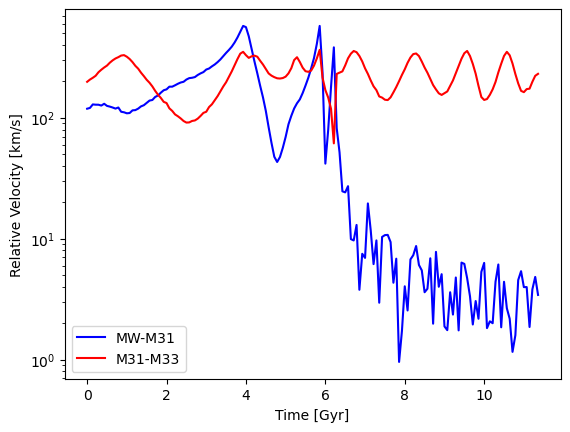

In [69]:
# Plot a zoom of the MW-M31 Orbit, using log y axis 
# To answer Q3 
#################################
times = MW_Orbit[:,0]

plt.semilogy()
plt.plot(times, MW_M31_RelVel, c='blue', label='MW-M31')
plt.plot(times, M31_M33_RelVel, c='red', label='M31-M33')
plt.legend()
plt.xlabel('Time [Gyr]')
plt.ylabel('Relative Velocity [km/s]')
plt.savefig('MW_M31_M33_RelVel.png')

plt.show()




#### Question 3

##### a) The merger seems to happen in 6.5 Gyr, then the separation stabilizes
##### b) M33's orbit seems to decay after the merger, making it come closer to the new merged galaxies 